<a href="https://colab.research.google.com/github/Bibhash123/Project-Primary-Quantization/blob/main/experiments/Tondi's_Method_Adversarial_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/andreacos/CnnJpegPrimaryQuantizationEstimation.git

Cloning into 'CnnJpegPrimaryQuantizationEstimation'...
remote: Enumerating objects: 459, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 459 (delta 15), reused 66 (delta 10), pack-reused 384
Receiving objects: 100% (459/459), 11.67 MiB | 15.05 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [ ]:
from IPython.display import clear_output
!pip install -q foolbox
!pip install -q eagerpy
clear_output(wait=False)

In [ ]:
from google.colab import files
_ = files.upload()
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
# !kaggle datasets download -d "bibhash123/firstquantest"
# !unzip -q firstquantest.zip -d "/content/Data/"
# !rm -r firstquantest.zip
!kaggle datasets download -d "bibhash123/tondidataset"
!unzip -q tondidataset.zip -d "/content/Data/"
!rm -r tondidataset.zip

Saving kaggle.json to kaggle.json
 99% 575M/582M [00:06<00:00, 109MB/s] 
100% 582M/582M [00:06<00:00, 98.7MB/s]


In [ ]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
from keras.models import load_model
from tqdm.notebook import tqdm

import eagerpy as ep
import foolbox
from foolbox import TensorFlowModel
from foolbox.attacks import FGSM
from foolbox.criteria import Misclassification
from PIL import Image

sns.set_style('darkgrid')

In [ ]:
def preprocess_input(im_file, target_size, scale=255.):
    """ 
        Read image and (eventually) scale data
        Arguments:
            im_file     : input image file
            target_size : output size of the image (height, width)
            scale       : pixel scaling value
        Returns: The image
    """
    file_bytes = tf.io.read_file(im_file)
    img = tf.image.decode_png(file_bytes, channels = 0)
    # Normalize and Resize
    if img.shape != target_size:
        img = tf.image.resize(img, target_size)
    img = tf.cast(img/255.0, tf.float32)
    return img

In [ ]:
def string2Q(s, size=(8, 8), flatten=True):
    """ Converts a comma separated string to a matrix.
        Keyword arguments:
        sq : input string
        size : output matrix size
    """
    if flatten:
        return tf.strings.to_number(tf.strings.split(s,','),out_type=tf.int32)
    else:
        return tf.reshape(tf.strings.to_number(tf.strings.split(s,','),out_type=tf.int32),size)

In [ ]:
def get_label(im_label):
    return string2Q(im_label)[:15]

In [ ]:
files = pd.read_csv("/content/Data/test.csv",sep=";",header=None,
                         names=['idx', 'filenames', 'quality1', 'quality2', 'software', 'labels',
                                'shift_r', 'shift_c']
                         )

files.head()

,idx,filenames,quality1,quality2,software,labels,shift_r,shift_c
0,0,/content/Data/Test/95-90/00000000_r12c5f70bt.T...,95,90,python-opencv,"2,1,1,1,1,1,2,1,1,1,2,2,2,2,2,4,3,2,2,2,2,5,4,...",5,4
1,1,/content/Data/Test/95-90/00000001_r12c5f70bt.T...,95,90,python-opencv,"2,1,1,1,1,1,2,1,1,1,2,2,2,2,2,4,3,2,2,2,2,5,4,...",5,4
2,2,/content/Data/Test/95-90/00000002_r12c5f70bt.T...,95,90,python-opencv,"2,1,1,1,1,1,2,1,1,1,2,2,2,2,2,4,3,2,2,2,2,5,4,...",5,4
3,3,/content/Data/Test/95-90/00000003_r12c5f70bt.T...,95,90,python-opencv,"2,1,1,1,1,1,2,1,1,1,2,2,2,2,2,4,3,2,2,2,2,5,4,...",5,4
4,4,/content/Data/Test/95-90/00000004_r12c5f70bt.T...,95,90,python-opencv,"2,1,1,1,1,1,2,1,1,1,2,2,2,2,2,4,3,2,2,2,2,5,4,...",5,4


In [ ]:
files['quality1'].unique()

array([95, 90, 75, 60, 70, 80, 85, 98, 65])

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def build_decoder(is_labelled):
  def if_labelled(path,label,target_size):
    image = preprocess_input(path,target_size)
    label = get_label(label)
    return image,label
  
  return if_labelled if is_labelled else preprocess_input

def create_dataset(df, batch_size = 32, is_labelled = False, repeat = False, shuffle = False, batch=False, cache=False):
    decode_fn = build_decoder(is_labelled)
    
    # Create Dataset
    if is_labelled:
        dataset = tf.data.Dataset.from_tensor_slices((df['filenames'].values,df["labels"].values))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((df['filenames'].values))

    dataset = dataset.map(partial(decode_fn,target_size=(64,64)), num_parallel_calls = AUTOTUNE)
    dataset = dataset.cache("") if cache else dataset
    dataset = dataset.repeat() if repeat else dataset
    dataset = dataset.shuffle(1024, reshuffle_each_iteration = True) if shuffle else dataset
    dataset = dataset.batch(batch_size,drop_remainder=True) if batch else dataset
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
def getX(X,Y):
  return X
def getY(X,Y):
  return Y

In [ ]:
test_set = create_dataset(files, 
                          batch_size = 32, 
                          is_labelled = True, 
                          repeat = False, 
                          shuffle = False,
                          batch=True,
                          cache=False)

model = load_model('/content/CnnJpegPrimaryQuantizationEstimation/models/pre_trained/DNN90_60LOG.h5')
model.compile(loss='mse',optimizer='adam')

In [ ]:
max_size = 960//32
images, labels = [],[]

for a,b in test_set.as_numpy_iterator():
  images.append(a)
  labels.append(b)
  if len(images)>max_size:
    break

images = tf.constant(np.concatenate(images, axis = 0))
labels = tf.constant(np.concatenate(labels, axis = 0))

In [ ]:
labels.shape

TensorShape([992, 15])

In [ ]:
images.shape

TensorShape([992, 64, 64, 1])

In [ ]:
pred = model.predict(images)
print("Initial Model Accuracy:",np.sum(np.round(pred)==labels)/(15*images.shape[0]))

Initial Model Accuracy: 0.7760752688172043


In [ ]:
loss_object = tf.keras.losses.LogCosh()

def create_adversarial_pattern(model, input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(tf.expand_dims(input_image,axis = 0))
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

perturbations = create_adversarial_pattern(model, images[1], labels[1])

In [ ]:
def attack(model, images, labels, epsilons):
  advs = []
  for idx in tqdm(range(images.shape[0]), "Performing FGSM attack:"):
    perturbations = create_adversarial_pattern(model, images[idx], labels[idx])
    temp = []
    for eps in epsilons:
      temp.append(images[idx][:,:,0]+eps*perturbations[:,:,0])
    advs.append(np.stack(temp,axis=0))
  return np.stack(advs,axis = 1)

In [ ]:
epsilon = np.linspace(0.0, 0.01, num=20)
advs = attack(model, images, labels, epsilon)

Performing FGSM attack::   0%|          | 0/992 [00:00<?, ?it/s]

In [ ]:
advs.shape

(20, 992, 64, 64)

  Epsilon ≤ 0.000000: 77.6 %
  Epsilon ≤ 0.000526: 37.0 %
  Epsilon ≤ 0.001053: 25.5 %
  Epsilon ≤ 0.001579: 32.3 %
  Epsilon ≤ 0.002105: 27.6 %
  Epsilon ≤ 0.002632: 24.1 %
  Epsilon ≤ 0.003158: 22.2 %
  Epsilon ≤ 0.003684: 21.4 %
  Epsilon ≤ 0.004211: 21.8 %
  Epsilon ≤ 0.004737: 23.0 %
  Epsilon ≤ 0.005263: 22.1 %
  Epsilon ≤ 0.005789: 20.6 %
  Epsilon ≤ 0.006316: 15.3 %
  Epsilon ≤ 0.006842: 15.4 %
  Epsilon ≤ 0.007368: 15.8 %
  Epsilon ≤ 0.007895: 14.9 %
  Epsilon ≤ 0.008421: 14.7 %
  Epsilon ≤ 0.008947: 13.8 %
  Epsilon ≤ 0.009474: 13.2 %
  Epsilon ≤ 0.010000: 13.1 %


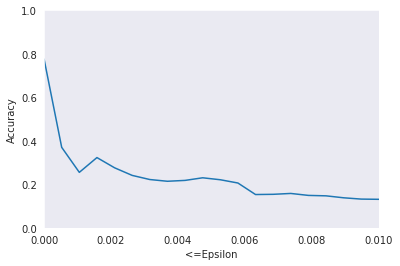

In [ ]:
epsilons, accuracy = [],[]
for eps, advs_ in tqdm(zip(np.linspace(0.0, 0.01, num=20), advs)):
  pred = model.predict(advs_)
  acc2 = np.sum(np.round(pred)==labels)/(15*images.shape[0])
  epsilons.append(eps)
  accuracy.append(acc2)
  print(f"  Epsilon ≤ {eps:.6f}: {acc2 * 100:4.1f} %")
  if acc2 == 0:
      break
plt.figure()
plt.plot(epsilons,accuracy)
plt.grid()
plt.xlim(0,0.01)
plt.ylim(0,1)
plt.xlabel("<=Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
!kaggle datasets download -d "bibhash123/primary-quant-scripts"
!unzip primary-quant-scripts.zip -d "/content/models"
!rm -r primary-quant-scripts.zip

  0% 0.00/5.44M [00:00<?, ?B/s]
100% 5.44M/5.44M [00:00<00:00, 58.2MB/s]
Archive:  primary-quant-scripts.zip
  inflating: /content/models/model.hdf5  
  inflating: /content/models/model_a.hdf5  
  inflating: /content/models/model_two.hdf5  
  inflating: /content/models/predict.py  
  inflating: /content/models/predict_a.py  


In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.activations import softmax

class CrossAttention(L.Layer):
    def __init__(self,input_dim, hidden_dim, output_dim):
        super(CrossAttention,self).__init__()
        self.w_k = self.add_weight(name='key', shape = (input_dim,hidden_dim), initializer="random_normal", trainable=True)
        self.w_q = self.add_weight(name='query', shape = (input_dim,hidden_dim), initializer="random_normal", trainable=True)
        self.w_v = self.add_weight(name='value', shape = (input_dim,output_dim), initializer="random_normal", trainable=True)

    def call(self,X1,X2):
        dims = 5
        key = tf.expand_dims(tf.matmul(X1,self.w_k),axis=1)
        query = K.concatenate([tf.expand_dims(tf.matmul(X2[:,i,:],self.w_q),axis=2) for i in range(dims)],axis=2)
        value = K.concatenate([tf.expand_dims(tf.matmul(X2[:,i,:],self.w_v),axis=2) for i in range(dims)],axis=2)
        score = tf.matmul(tf.nn.softmax(tf.matmul(key,query),axis=-1),tf.transpose(value,perm=[0,2,1]))
        return score[:,0,:]

class cfg:
    q_factors = [(60, 90), (65, 90), (70, 90), (75, 90), (80, 90), (85, 90), 
                               (90, 90), (95, 90), (98, 90)]
    test_csv = "/content/Data/test.csv"
    scaling_factor_data = 255.0
    max_no_Q_coefs = 15
    result_dir = '/content/results/'
    block_size = (64, 64) 
    rgb = True
    coeffs_low = [13,9,10,11,10,8,13,11,10,11,14,14,13,15,19,32,21,19,18,18,19,39,28,30,23,32,46,41,49,48,46,41,45,44,51,58,74,62,51,54,70,55,44,45,64,87,65,70,76,78,82,83,82,50,62,90,97,90,80,96,74,81,82,79]
    max_vals = coeffs_low[:15]
    num_outputs = np.sum(max_vals)
    batch_size = 32

def custom_softmax_activation(max_vals):

    """
    Params:
    =======================================
    max_vals: qm values for i from 1 to 15
    """
    bins = np.concatenate(([0], np.cumsum(max_vals))).astype(np.int16)
    def custom_softmax(x):
        stack_list = [softmax(x[:, int(bins[i]):int(bins[i + 1])]) for i in range(0, len(bins)-1)]
        return tf.concat(stack_list, axis=-1)

    return custom_softmax


In [ ]:
from densenet import DenseNet

K.clear_session()
with tf.device('/GPU:0'):
    err_model,_ = DenseNet(input_shape = (64,64,1), nb_classes = 15, depth=24)
    err_model = tf.keras.Model(inputs=err_model.input, outputs = err_model.layers[-2].output)
    img_model,_ = DenseNet(input_shape = (64,64,1), nb_classes = 15, depth=24)
    img_model = tf.keras.Model(inputs=img_model.input, outputs = img_model.layers[-2].output)

    inp1 = L.Input(shape=(64,64,1))
    inp2 = L.Input(shape=(5,64,64,1))
    h1 = img_model(inp1)
    h2 = L.TimeDistributed(err_model)(inp2)
    h2 = L.TimeDistributed(L.Flatten())(h2)
    h2 = L.TimeDistributed(L.Dense(128,activation='relu'))(h2)
    h1 = L.Flatten()(h1)
    h1 = L.Dense(128,activation='relu')(h1)
    
    h = CrossAttention(128,128,128)(h1,h2)
    h = L.Dense(cfg.num_outputs,activation= custom_softmax_activation(cfg.max_vals))(h)
    model = tf.keras.Model(inputs = [inp1,inp2],
                         outputs = h)

    opt = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    model.compile(loss = "mse", optimizer = opt, metrics=  ['accuracy'])
    model.summary()
    model.load_weights('/content/models/model_a.hdf5')

Creating DenseNet
#############################################
Dense blocks: 3
Layers per dense block: [6, 6, 6]
#############################################
Creating DenseNet
#############################################
Dense blocks: 3
Layers per dense block: [6, 6, 6]
#############################################
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 5, 64, 64,   0           []                               
                                1)]                                                               
                                                                     

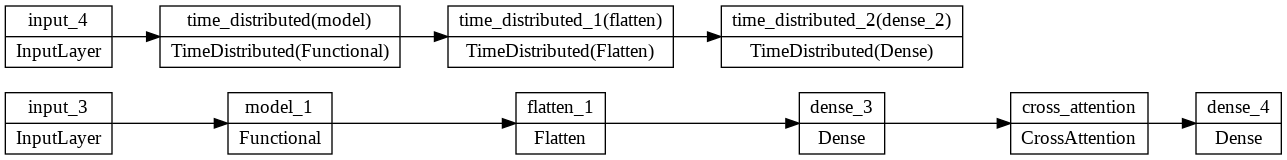

In [ ]:
tf.keras.utils.plot_model(model,to_file = "model.png", rankdir = "LR")

In [ ]:
def convert_coeffs(pred):
    preds = []
    bins = np.concatenate(([0], np.cumsum(cfg.max_vals))).astype(np.int)
    for i in range(0, len(bins) - 1):
        y_true_to_coeff = tf.argmax(pred[bins[i]:bins[i+1]]) + 1
        preds.append(y_true_to_coeff)
    preds = np.array(preds)
    return preds

In [ ]:
pred = convert_coeffs(model.predict(images))
print("Initial Model Accuracy:",np.sum(np.round(pred)==labels)/(15*images.shape[0]))

  Epsilon ≤ 0.000000: 67.6 %
  Epsilon ≤ 0.000526: 57.0 %
  Epsilon ≤ 0.001053: 55.5 %
  Epsilon ≤ 0.001579: 56.3 %
  Epsilon ≤ 0.002105: 53.6 %
  Epsilon ≤ 0.002632: 51.1 %
  Epsilon ≤ 0.003158: 48.2 %
  Epsilon ≤ 0.003684: 46.4 %
  Epsilon ≤ 0.004211: 43.8 %
  Epsilon ≤ 0.004737: 38.0 %
  Epsilon ≤ 0.005263: 37.1 %
  Epsilon ≤ 0.005789: 35.6 %
  Epsilon ≤ 0.006316: 36.3 %
  Epsilon ≤ 0.006842: 27.4 %
  Epsilon ≤ 0.007368: 25.8 %
  Epsilon ≤ 0.007895: 23.9 %
  Epsilon ≤ 0.008421: 21.7 %
  Epsilon ≤ 0.008947: 19.8 %
  Epsilon ≤ 0.009474: 19.2 %
  Epsilon ≤ 0.010000: 18.1 %


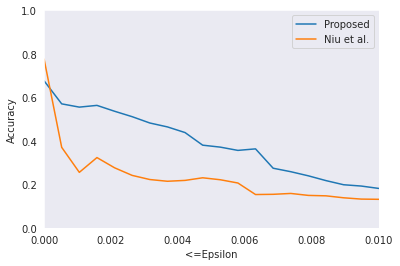

In [ ]:
epsilons, accuracy = [],[]
for eps, advs_ in zip(np.linspace(0.0, 0.01, num=20), advs):
  pred = model.predict(advs_)
  acc2 = np.sum(np.round(pred)==labels)/(15*images.shape[0])
  epsilons.append(eps)
  accuracy.append(acc2)
  print(f"  Epsilon ≤ {eps:.6f}: {acc2 * 100:4.1f} %")
  if acc2 == 0:
      break

prev_acc = np.array([77.6 ,37.0 ,25.5 ,32.3, 27.6, 24.1, 22.2, 21.4, 21.8, 23.0, 22.1,
  20.6 , 15.3 ,15.4 , 15.8 , 14.9 , 14.7 , 13.8 , 13.2 , 13.1])/100
plt.figure()
plt.plot(epsilons,accuracy, label = "Proposed")
plt.plot(epsilons,prev_acc, label = "Niu et al.")
plt.grid()
plt.xlim(0,0.01)
plt.ylim(0,1)
plt.xlabel("<=Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("attack.pdf")
plt.show()